# Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install salib
from SALib.sample import saltelli
from SALib.analyze import sobol

In [ ]:
# Used for styling of graphs
!pip install SciencePlots

import scienceplots
plt.style.use(['science', 'grid', 'no-latex'])

# Creating Model

In [ ]:
from scipy.optimize import curve_fit

# Initialises data
xData = np.array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])
yData = np.array([98, 173, 279, 422, 588, 716, 854, 907, 1139, 1364, 1637, 2074, 2767, 3397])
xData -= np.min(xData)

# Defines the exponential function
def exponential(xData, a, b):
  return a * b ** xData

# Calculates the paramaters of the model
popt, pcov = curve_fit(exponential, xData, yData,
                       bounds=([0, 0], [np.inf, np.inf]), maxfev=10000)

# Creates function for the model with the found parameters
model = lambda xData: exponential(xData, *popt)

[201.47793073   1.24149628]


# Sensitivity Analysis

In [ ]:
paramNames = np.array(['a', 'b'])

# Defines parameters and bounds for the sensitivity analysis
problem = {
    'num_vars': len(paramNames),
    'names': paramNames,
    'bounds': [[x * 0.95, x * 1.05] for x in popt]
}

In [ ]:
# Creates samples
paramValues = saltelli.sample(problem, 64)

# Evaluates samples over relevant domain for each parameter set
x = np.linspace(0, 30, 100)
y = np.array([exponential(x, *params) for params in paramValues])

# Calculates the indicies of the parameters at each x value
sobolIndices = [sobol.analyze(problem, Y) for Y in y.T]

<ipython-input-82-0af21a35a0f2>:2: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  paramValues = saltelli.sample(problem, 64)


[[1.91876248e+02 2.04242485e+02 2.17405714e+02 ... 8.20603707e+04
  8.73490816e+04 9.29786448e+04]
 [2.07931521e+02 2.21332505e+02 2.35597169e+02 ... 8.89267840e+04
  9.46580286e+04 1.00758646e+05]
 [1.91876248e+02 2.06936917e+02 2.23179721e+02 ... 2.92581309e+05
  3.15546476e+05 3.40314216e+05]
 ...
 [1.91561439e+02 2.05358539e+02 2.20149367e+02 ... 1.62990229e+05
  1.74729505e+05 1.87314294e+05]
 [2.02579763e+02 2.17373192e+02 2.33246914e+02 ... 1.88694246e+05
  2.02473682e+05 2.17259364e+05]
 [2.02579763e+02 2.17170451e+02 2.32812025e+02 ... 1.72365181e+05
  1.84779681e+05 1.98088329e+05]]


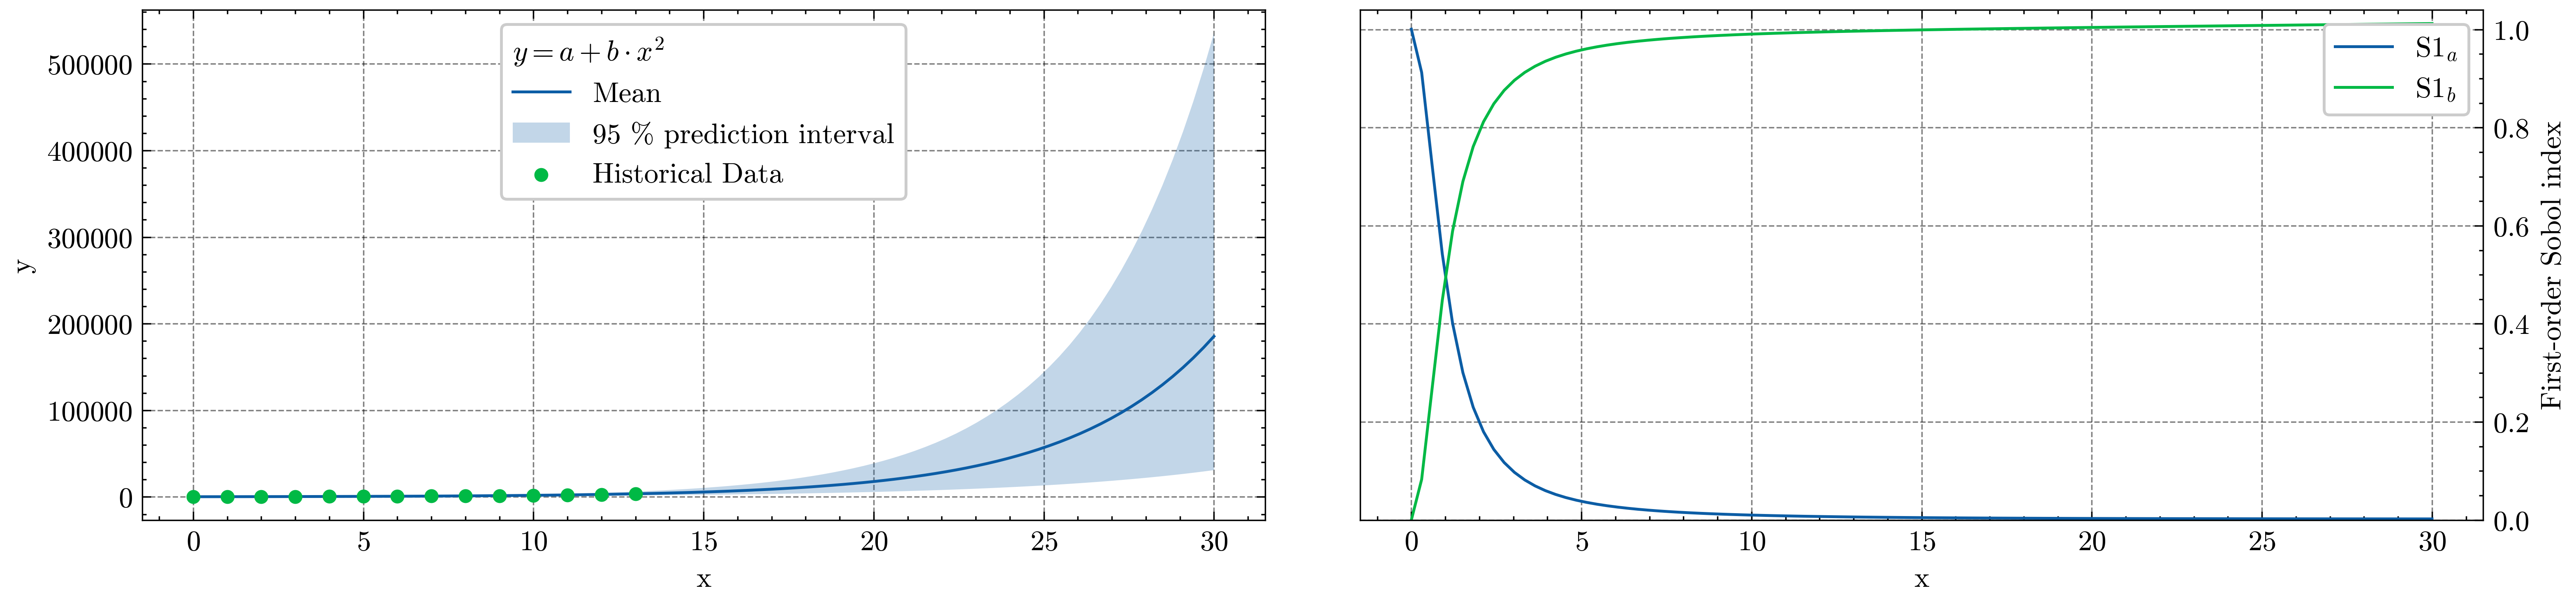

In [ ]:
# Retrieves the first order indicies
s1Sense = np.array([s['S1'] for s in sobolIndices])
PREDICTION_INTERVAL = 95

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=500)
fig.tight_layout()

# Plots the first order indicies agains x
for i in range(len(paramNames)):
  axes[1].plot(x, s1Sense[:, i],
          label=f'S1$_{paramNames[i]}$')

axes[1].set_xlabel("x")
axes[1].set_ylabel("First-order Sobol index")

axes[1].set_ylim(0, 1.04)

axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()

axes[1].legend(loc='upper right')


axes[0].plot(x, np.mean(y, axis=0), label="Mean")


# Plots the confidence region within the prediction interval
axes[0].fill_between(x,
                 np.percentile(y, 50 - PREDICTION_INTERVAL/2., axis=0),
                 np.percentile(y, 50 + PREDICTION_INTERVAL/2., axis=0),
                 alpha=0.25,
                 label=f"{PREDICTION_INTERVAL} % prediction interval")

axes[0].scatter(xData, yData, marker="o", s=15, label="Historical Data", zorder=2)

axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].legend(title=r"$y=a+b\cdot x^2$",
           loc='upper center')._legend_box.align = "left"

plt.show()